# Initial training

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

start = time.time()


path = 'smoke_detection_iot.csv'

data = pd.read_csv(path).drop(['Unnamed: 0', 'UTC', 'CNT'], axis=1)
Y_df = data['Fire Alarm']
X_df = data.drop('Fire Alarm', axis=1)

Y_test_raw = X_df.values
Y_raw = Y_df.values

X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(Y_test_raw, Y_raw, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

In [2]:
from alarmnetclass import AlarmNet
import torch
from torch import nn

alpha = 1e-2
epochs = 3000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
full_model = AlarmNet(
    num_features=X_train_raw.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)

X_train_raw_device = torch.tensor(X_train_raw).float().to(device)
X_test_raw_device = torch.tensor(X_test_raw).float().to(device)
Y_train_raw_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_raw_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

full_model.train(
    epochs=4000,
    X_train=X_train_raw_device,
    X_test=X_test_raw_device,
    Y_train=Y_train_raw_device,
    Y_test=Y_test_raw_device,
    alpha=1e-3,
    print_epoch = 500
)
full_model.print_results()
full_model.plot_training("Full Model Loss Curves")

----------------------------------------
| Epoch | Training Loss |  Test Loss   | Recall |
----------------------------------------
|     0 |  0.6896733642 | 0.6858862042 | 0.9987669544 |
----------------------------------------
|   500 |  0.0581393726 | 0.0582862161 | 0.9847550723 |
----------------------------------------
|  1000 |  0.0224225074 | 0.0222017355 | 0.9958524829 |
----------------------------------------
|  1500 |  0.0066215070 | 0.0061535449 | 0.9996637148 |
----------------------------------------
|  2000 |  0.0027742172 | 0.0026526016 | 0.9997758099 |
----------------------------------------
|  2500 |  0.0015627561 | 0.0015917902 | 0.9997758099 |
----------------------------------------
|  3000 |  0.0010200874 | 0.0011528449 | 0.9997758099 |
----------------------------------------


KeyboardInterrupt: 

# Feature Analysis
- Initially there are 15 features
- 3 are unusable
    - UTC Timestamp
    - CNT
    - Unnamed: 0
- 12 features are usable

In [3]:
import numpy as np



corr = np.abs(data.corr())
ranking = corr['Fire Alarm'].sort_values(ascending=False)[1:]
print(ranking)

Humidity[%]       0.399846
Raw Ethanol       0.340652
Pressure[hPa]     0.249797
TVOC[ppb]         0.214743
Temperature[C]    0.163902
NC0.5             0.128118
PM1.0             0.110552
Raw H2            0.107007
eCO2[ppm]         0.097006
PM2.5             0.084916
NC1.0             0.082828
NC2.5             0.057707
Name: Fire Alarm, dtype: float64


In [ ]:
num_drops = 8
remaining_features = ranking.index[:-num_drops]


X_df_dropped = data[remaining_features]
print('Remaining features:', X_df_dropped.columns)
X_train_dropped, X_test_dropped, Y_train_dropped, Y_test_dropped = train_test_split(X_df_dropped.values, Y_raw, test_size=0.2, random_state=0)

X_train_dropped = scaler.fit_transform(X_train_dropped)
X_test_dropped = scaler.transform(X_test_dropped)


Remaining features: Index(['Humidity[%]', 'Raw Ethanol', 'Pressure[hPa]', 'TVOC[ppb]'], dtype='object')


In [5]:
dropped_model = AlarmNet(
    num_features=X_train_dropped.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 64]
    
).to(device)

X_train_dropped_device = torch.tensor(X_train_dropped).float().to(device)
X_test_dropped_device = torch.tensor(X_test_dropped).float().to(device)
Y_train_dropped_device = torch.tensor(Y_train_dropped).float().view(-1, 1).to(device)
Y_test_dropped_device = torch.tensor(Y_test_dropped).float().view(-1, 1).to(device)

dropped_model.train(
    epochs=4000,
    X_train=X_train_dropped_device,
    X_test=X_test_dropped_device,
    Y_train=Y_train_dropped_device,
    Y_test=Y_test_dropped_device,
    alpha=1e-3,
    print_epoch = 500
)
dropped_model.print_results()
AlarmNet.compare_results(dropped_model.get_results(), full_model.get_results())
dropped_model.plot_training("Dropped Model Loss Curves")

----------------------------------------
| Epoch | Training Loss |  Test Loss   | Recall |
----------------------------------------
|     0 |  0.6745014191 | 0.6646675467 |  1.00 |
----------------------------------------


KeyboardInterrupt: 

## Feature Analysis Results
- We can remove the bottom 8 features and have a model that only loses 0.1% precision, and even less for every other metric
- A 4 feature model is almost perfect
    - These features are:
        - Humidity
        - Raw Ethanol
        - Pressure
        - TVOC
- Note that the Particulate Matter sensor is not included in the 4-feature model.
    - To add redundancy to our model, we can add back the most correlated feature from the PM sensor
    - This feature is PM0.5




In [6]:

# Add back the most correlated PM feature, so that all 4 sensors are used
# PM0.5 is the most correlated PM feature, with index 5
remaining_features_2 = list(remaining_features)
remaining_features_2.append(ranking.index[5])
X_5f = data[remaining_features_2]
X_train_5f, X_test_5f, Y_train_5f, Y_test_5f = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)



scaler = StandardScaler()
X_train_5f_scaled = scaler.fit_transform(X_train_5f)
X_test_5f_scaled = scaler.transform(X_test_5f)

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.7017015815 | 0.6505813599 |
----------------------------------------
|   500 |  0.0114294905 | 0.0118126152 |
----------------------------------------
|  1000 |  0.0080650942 | 0.0096294023 |
----------------------------------------
|  1500 |  0.0060001086 | 0.0074493368 |
----------------------------------------
|  2000 |  0.0054470613 | 0.0069829901 |
----------------------------------------
|  2500 |  1.1027877331 | 8.3414649963 |
----------------------------------------
|  2999 |  0.0254407618 | 0.0268058777 |
----------------------------------------
Accuracy: 0.9964074724572889
Precision: 0.9956444047353138
Recall: 0.9993274296603519
F1: 0.9974825174825175
Confusion_matrix:
[[3566   39]
 [   6 8915]]
Classification_report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3605
         1.0     

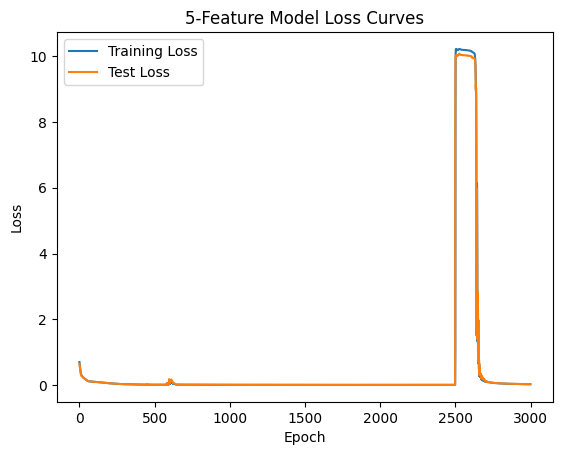

In [7]:

dropped_model_5 = AlarmNet(
    num_features=X_train_5f_scaled.shape[1],  # Update to match the new input dimensions
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)
epochs = 3000
alpha = 1e-2

X_train_5f_device = torch.tensor(X_train_5f_scaled).float().to(device)
X_test_5f_device = torch.tensor(X_test_5f_scaled).float().to(device)
Y_train_5f_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_5f_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

dropped_model_5.train(epochs, X_train_5f_device, X_test_5f_device, Y_train_5f_device, Y_test_5f_device, alpha)

dropped_model_5_results = dropped_model_5.get_results()
dropped_model_5.print_results()

AlarmNet.compare_results(dropped_model_5_results, dropped_model.get_results())

dropped_model_5.plot_training("5-Feature Model Loss Curves")


# Outlier Removal
- The curve above has an odd spike in the middle of training. This may be due to the heavily biased distributions of the NC0.5 and TVOC features

array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

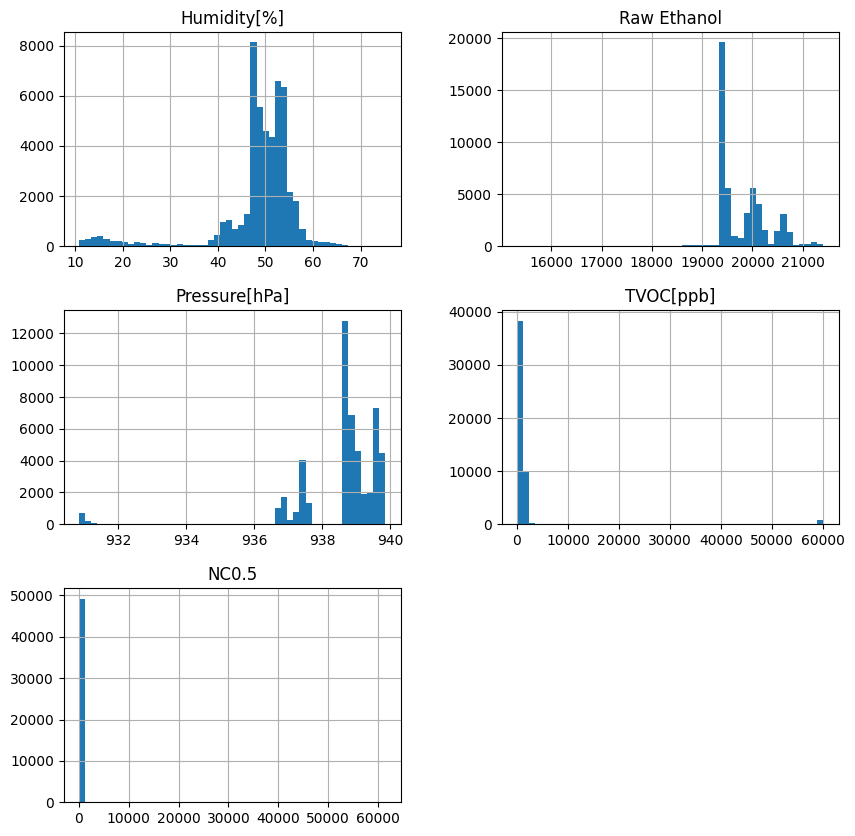

In [8]:
#X_train_5f_scaled, X_test_5f_scaled, Y_train_5f, Y_test_5f = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)

X_train_5f.hist(
    figsize=(10, 10),
    bins=50
    )

## Outlier Removal
- The majority of the data in the NC0.5 feature lies below 30, and the majority of the data in the TVOC feature lies below 1500
- By removing the data above these thresholds, we can remove the bias from the data and produce a much more even distribution
- However, this filter cannot be applied to the validation data, as the real sensor data will likely follow the original skewed distribution

Data reduction: 5.79%


array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

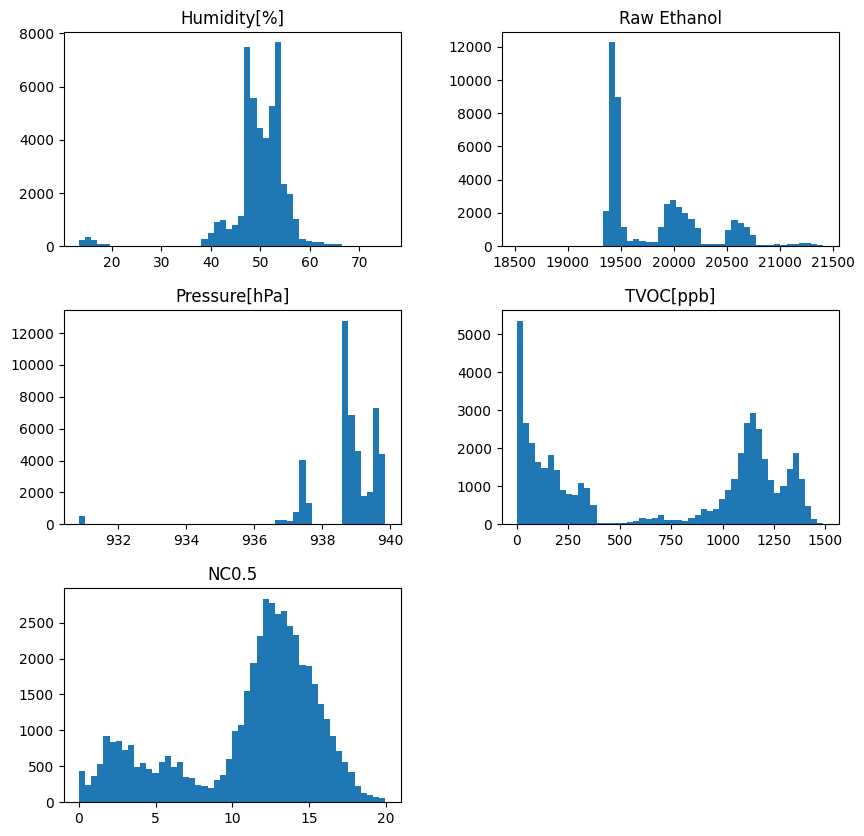

In [9]:
import matplotlib.pyplot as plt

TVOC_threshold = 1500
NC0_5_threshold = 20

X_train_outlier, X_test_outlier, Y_train_outlier, Y_test_outlier = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)

X_train_outlier =  X_train_outlier[(X_train_outlier['TVOC[ppb]'] < TVOC_threshold) & (X_train_outlier['NC0.5'] < NC0_5_threshold)]
Y_train_outlier = Y_train_outlier[X_train_outlier.index]

data_reduction = 100*(1 - X_train_outlier.shape[0] / X_train_5f_scaled.shape[0])
print(f'Data reduction: {data_reduction:.2f}%')

X_train_outlier.hist(
    figsize=(10, 10),
    grid=False,
    bins=50
)

## Improved Distribution
- The training data is much more evenly distributed.
- However, it does not make sense to apply this filter to the validation data, as the real sensor values will follow the original distribution

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6911694407 | 0.6896510124 |
----------------------------------------
|   500 |  0.1928691566 | 0.3361483216 |
----------------------------------------
|  1000 |  0.1127852201 | 0.2673608959 |
----------------------------------------
|  1500 |  0.0943800882 | 0.6330030560 |
----------------------------------------
|  2000 |  0.0745901242 | 2.5554618835 |
----------------------------------------
|  2500 |  0.0452654734 | 3.1301767826 |
----------------------------------------
|  3000 |  0.0241017453 | 3.7568862438 |
----------------------------------------
|  3500 |  0.0142155597 | 4.0795283318 |
----------------------------------------
|  3999 |  0.0091769192 | 4.2356038094 |
----------------------------------------
Accuracy: 0.9532173079993613
Precision: 0.9410519631707059
Recall: 0.9967492433583679
F1: 0.9681001633097441
Confusion_matrix:
[[3048  557]

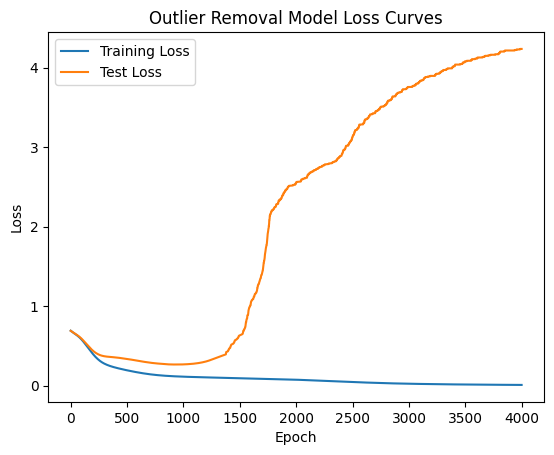

In [10]:
#remove all rows where TVOC>3000 or NC0.5>4000

scaler = StandardScaler()
scaler.fit(X_train_5f)
X_train_outlier_scaled = scaler.transform(X_train_outlier)
X_test_outlier_scaled = scaler.transform(X_test_5f)


X_train_outlier_device = torch.tensor(X_train_outlier_scaled).float().to(device)
X_test_outlier_device = torch.tensor(X_test_outlier_scaled).float().to(device)
Y_train_outlier_device = torch.tensor(Y_train_outlier.values).float().view(-1, 1).to(device)
Y_test_outlier_device = torch.tensor(Y_test_5f.values).float().view(-1, 1).to(device)

outlier_model = AlarmNet(
    num_features=X_train_outlier.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 128, 64]
).to(device)

outlier_model.train(
    epochs=4000,
    X_train=X_train_outlier_device,
    X_test=X_test_outlier_device,
    Y_train=Y_train_outlier_device,
    Y_test=Y_test_outlier_device,
    alpha=1e-4,
    print_epoch = 500
)
outlier_model.print_results()
AlarmNet.compare_results(outlier_model.get_results(), dropped_model_5_results)
outlier_model.plot_training("Outlier Removal Model Loss Curves")


# Imputation
- The training and validation datasets have completely different distributions
    - This causes overfitting
- Solution: Imputation
    - Replace each value above the threshold with the median of the feature
    - Chose median because it is a better measure of center than mean for skewed distributions


In [11]:
class Imputer:
    def __init__(self, thresholds: list[float]):
        self.thresholds = thresholds
    def fit(self, data: pd.DataFrame):
        self.replacements = data.median()

    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        for i, column in enumerate(data.columns):
            data[column] = data[column].apply(lambda x: self.replacements.iloc[i] if ( not (self.thresholds[i][0] < x < self.thresholds[i][1]) or np.isnan(x)) else x)
        return data
    def fit_transform(self, data: pd.DataFrame) -> pd.DataFrame:
        self.fit(data)
        return self.transform(data)

(50104, 5)


array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

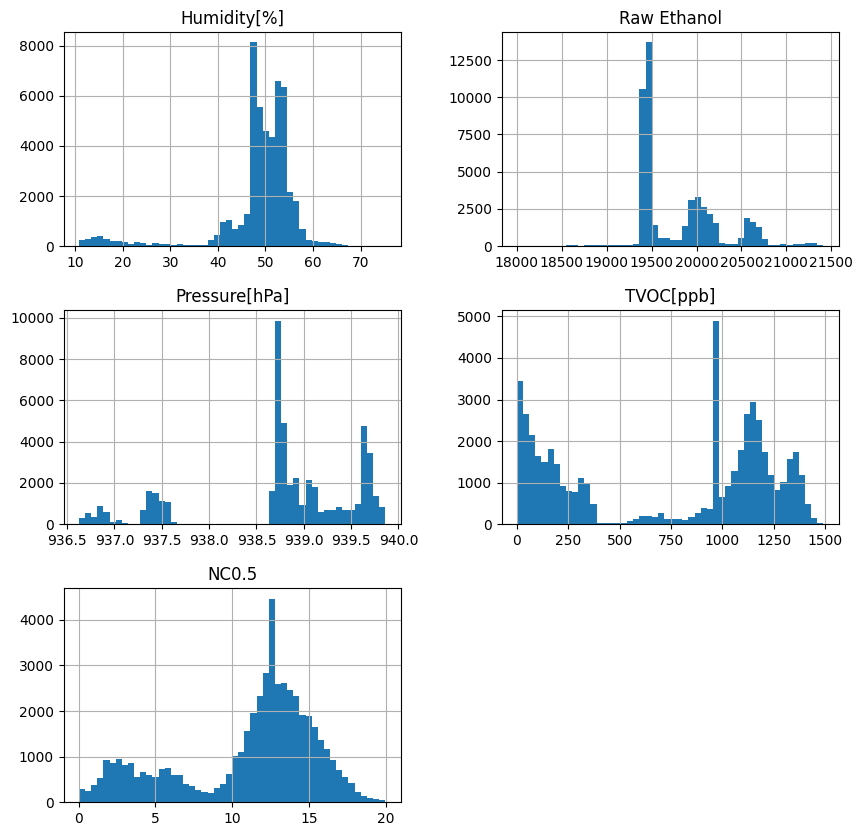

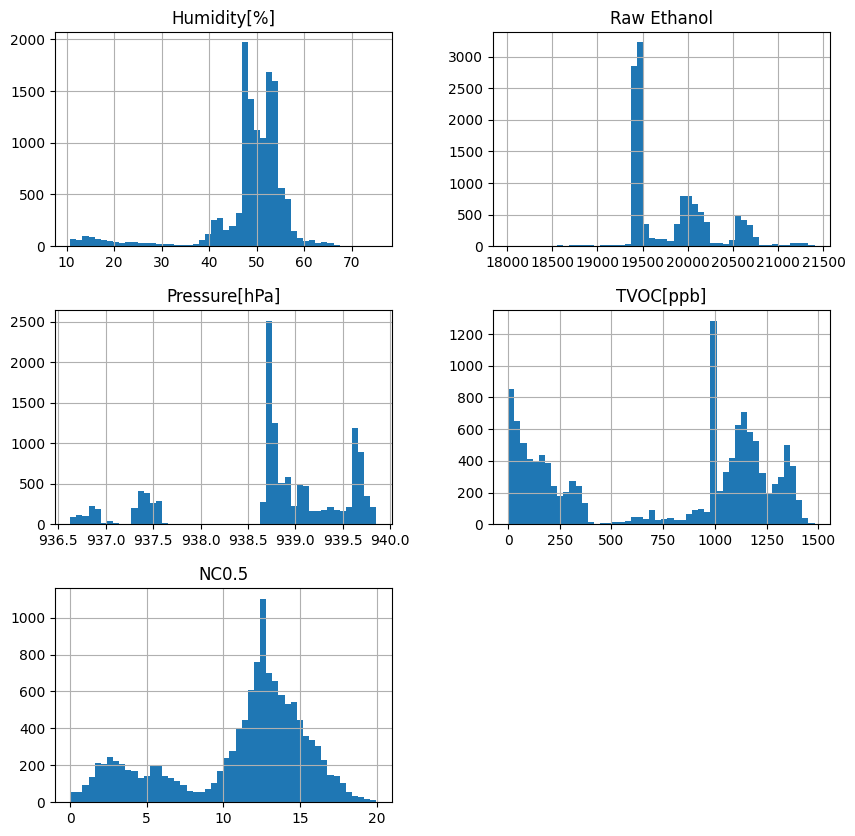

In [12]:
X_train_imputed, X_test_imputed, Y_train_imputed, Y_test_imputed = train_test_split(X_5f, Y_df.values, test_size=0.2, random_state=0)

thresholds = [(0,70000), (18000, 70000), (936, 70000), (0, 1500), (0,20)]
imputer = Imputer(thresholds)

X_train_imputed = imputer.fit_transform(X_train_imputed)
X_test_imputed = imputer.transform(X_test_imputed)

print(X_train_imputed.shape)
X_train_imputed.hist(
    figsize=(10, 10),
    bins=50
)
X_test_imputed.hist(
    figsize=(10, 10),
    bins=50
)
# print(X_train_5f.shape)
# print(X_train_imputed.shape)
# print(Y_train_imputed.shape)

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.7158954144 | 0.7083690763 |
----------------------------------------
|   500 |  0.0173460674 | 0.0190787371 |
----------------------------------------
|  1000 |  0.0046023191 | 0.0066720615 |
----------------------------------------
|  1500 |  0.0023013919 | 0.0039501488 |
----------------------------------------
|  2000 |  0.0014482919 | 0.0027257057 |
----------------------------------------
|  2500 |  0.0010308636 | 0.0021155446 |
----------------------------------------
|  3000 |  0.0007733653 | 0.0017951370 |
----------------------------------------
|  3500 |  0.0005808050 | 0.0015933637 |
----------------------------------------
|  3999 |  0.0004762385 | 0.0015752851 |
----------------------------------------
Accuracy: 0.9995209963276385
Precision: 0.9994397759103641
Recall: 0.999887904943392
F1: 0.999663790205088
Confusion_matrix:
[[3600    5]
 

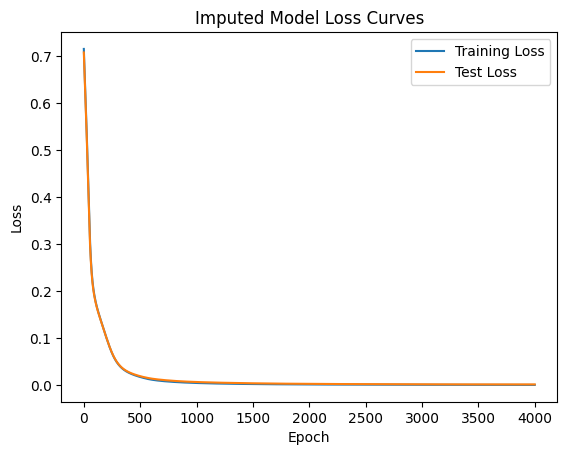

In [13]:

X_train_imputed_device = torch.tensor(scaler.fit_transform(X_train_imputed)).float().to(device)
X_test_imputed_device = torch.tensor(scaler.transform(X_test_imputed)).float().to(device)
Y_train_imputed_device = torch.tensor(Y_train_imputed).float().view(-1, 1).to(device)
Y_test_imputed_device = torch.tensor(Y_test_imputed).float().view(-1, 1).to(device)

imputed_model = AlarmNet(
    num_features=X_train_imputed.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
).to(device)

imputed_model.train(
    epochs=4000,
    X_train=X_train_imputed_device,
    X_test=X_test_imputed_device,
    Y_train=Y_train_imputed_device,
    Y_test=Y_test_imputed_device,
    alpha=1e-3,
    print_epoch = 500
)

imputed_model.print_results()
AlarmNet.compare_results(imputed_model.get_results(), dropped_model_5_results)
imputed_model.plot_training("Imputed Model Loss Curves")



# Error Handling
- The 12 initial features came from 4 sensors
    - Temp/Humidity
    - Pressure
    - Volatile Organic Compounds (CO2, Ethanol, H2, TVOC)
    - Particulate Matter (PM1, PM2.5, NC0.5, NC1, NC2.5)
- 3 of these sensors are redundant, with the exception being the PM sensor
    - This means that the features related to the PM sensor are twice as likely to be missing
- We can simulate a real world scenario by introducing error according to this distribution

In [14]:
import random

# Introduce sensor errors 

def insert_errors(data: pd.DataFrame, error_chance):

    VOC_features = [
        'TVOC[ppb]',
        'eCO2[ppm]',
        'Raw H2',
        'Raw Ethanol'
    ]

    PM_features = [
        'PM1.0',
        'PM2.5',
        'NC0.5',
        'NC1.0',
        'NC2.5'
    ]

    th_features = [
        'Temperature[C]',
        'Humidity[%]'
    ]
    pressure_features = [
        'Pressure[hPa]'
    ]

    # The PM sensor is twice as likely to fail due to lack of redundancy
    chances = [error_chance, error_chance*2, error_chance, error_chance]
    sensors = [VOC_features, PM_features, th_features, pressure_features]

    data_new = data.copy(deep=True).values
    for i, datapoint in enumerate(data_new):
        errored_features = []
        for j, sensor in enumerate(sensors):
            sensor_error = random.random() < chances[j]
            if sensor_error:
                errored_features.extend(sensor)
        errored_features = [feature for feature in errored_features if feature in data.columns]
        if errored_features:
            for feature in errored_features:
                data_new[i][data.columns.get_loc(feature)] = np.nan
            # print(i, X_error_np[i])
    return data_new

X_error = insert_errors(X_5f, 0.2)

X_train_error, X_test_error, Y_train_error, Y_test_error = train_test_split(X_error, Y_df.values, test_size=0.2, random_state=0)

In [15]:
imputer_2 = Imputer(thresholds)
X_train_error_imputed = imputer_2.fit_transform(pd.DataFrame(X_train_error, columns=X_5f.columns))
X_test_error_imputed = imputer_2.transform(pd.DataFrame(X_test_error, columns=X_5f.columns))
scaler = StandardScaler()
X_train_error_scaled = scaler.fit_transform(X_train_error_imputed)
X_test_error_scaled = scaler.transform(X_test_error_imputed)


In [16]:
measurement_count = X_error.shape[0]*X_error.shape[1]
error_count = np.count_nonzero(np.isnan(X_error))
error_rate = error_count / measurement_count
print(f"Measurement Count: {measurement_count}")
print(f"Error Count: {error_count}")
print(f'Error rate: {error_rate:.2f}')

Measurement Count: 313150
Error Count: 74937
Error rate: 0.24


----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6925072670 | 0.6923364997 |
----------------------------------------
|   500 |  0.3656601310 | 0.3609900177 |
----------------------------------------
|  1000 |  0.2327367663 | 0.2292562723 |
----------------------------------------
|  1500 |  0.1774629056 | 0.1734824032 |
----------------------------------------
|  2000 |  0.1469864845 | 0.1423070878 |
----------------------------------------
|  2500 |  0.1265848726 | 0.1219188869 |
----------------------------------------
|  3000 |  0.1116766483 | 0.1075080261 |
----------------------------------------
|  3500 |  0.1002011895 | 0.0965695679 |
----------------------------------------
|  4000 |  0.0907999426 | 0.0876863450 |
----------------------------------------
|  4500 |  0.0827615485 | 0.0802577883 |
----------------------------------------
|  5000 |  0.0757670179 | 0.0738938823 |
----------------

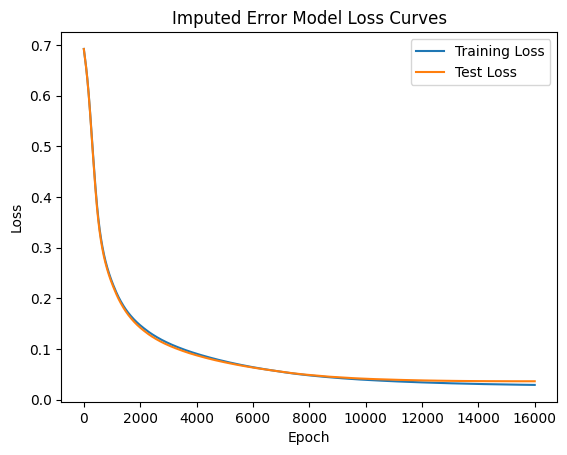

In [20]:
imputed_error_model = AlarmNet(
    num_features=X_train_error_scaled.shape[1],
    activation = nn.ReLU,
    hidden_layers=[256, 256, 256]
).to(device)

X_train_error_device = torch.tensor(X_train_error_scaled).float().to(device)
X_test_error_device = torch.tensor(X_test_error_scaled).float().to(device)
Y_train_error_device = torch.tensor(Y_train_error).float().view(-1, 1).to(device)
Y_test_error_device = torch.tensor(Y_test_error).float().view(-1, 1).to(device)

imputed_error_model.train(
    epochs=16000,
    X_train=X_train_error_device,
    X_test=X_test_error_device,
    Y_train=Y_train_error_device,
    Y_test=Y_test_error_device,
    alpha=1e-5,
    print_epoch = 500,
)

imputed_error_model.print_results()
AlarmNet.compare_results(imputed_error_model.get_results(), imputed_model.get_results())
imputed_error_model.plot_training("Imputed Error Model Loss Curves")


# Conclusion
- The error generation removed 24% of the data
- Yet, through imputation, only 0.6% more houses burned down
    - Recall decreased by 0.6% between the original and imputed datasets

In [18]:
end = time.time()
print(f'Time elapsed: {end-start:.2f} seconds')

Time elapsed: 369.55 seconds


## Error Modes
- Current features:
    - Humidity
    - Raw Ethanol
    - Pressure
    - TVOC
    - NC0.5
- Sensors:
    - Humidity
    - Pressure
    - Raw Ethanol/TVOC
    - NC0.5
- The model should be able to handle missing data in the case where at most 3 sensors have failed, because 4 failed sensors means no data
    - 1 failed sensor = 4c1 = 4
    - 2 failed sensors = 4c2 = 6
    - 3 failed sensors = 4c3 = 4
    - Total = 14
## Ensemble Training
- We can train 14 models that can predict the missing data for each error mode
- In the case of error, we select the model that corresponds to the error mode and use it to predict the missing data
- Then use the main model to predict the target
### Indexing Ensemble
- Columns should be rearranged according to sensors
    - Humidity, Pressure, NC0.5, Ethanol, TVOC, 
- The error mode can be represented as a 4-bit value
    - 0b0000 = No error
    - 0b0001 = Ethanol/TVOC Error
    - 0b0010 = NC0.5 Error
    - 0b0100 = Pressure error
    - 0b1000 = Humidity error
- A 5-bit value can represent which features are missing
    - 0b00000 = No error
    - 0b00011 = Ethanol/TVOC Error
    - 0b00100 = NC0.5 Error
    - 0b01000 = Pressure error
    - 0b10000 = Humidity error
- We can convert from the 5-bit value to the 4-bit value with a simple shift right operation

### Model Table
- Store the models with an array
- The index of the model is the error mode
- Model 15 will always predict 1, because if all sensors have failed the worst should be assumed for safety
- Model 0 will be the standard model trained on a full dataset
- The rest of the arrays will be trained on the data with the corresponding error mode
### New Model Type
- A new model class will be created that will predict the missing values, construct the repaired dataset, call the standard model, and return the result
### Ensemble Class
- This new class will hold the model table and the standard model
- It will be responsible for constructing the model address, calling the correct model, and returning the result



    

